# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
df = pd.read_csv("data/heart_disease_cleaned.csv")

label_col = "target"
X = df.drop(columns=[label_col])
y = df[label_col]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Features shape: (303, 25)
Target distribution:
 target
0    164
1    139
Name: count, dtype: int64


# Random Forest

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [4]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

"Top 10 features by Random Forest:\n", feat_imp.head(10)

('Top 10 features by Random Forest:\n',
       Feature  Importance
 11     cp_4.0    0.113932
 5          ca    0.108169
 4     oldpeak    0.098596
 3     thalach    0.086814
 22   thal_3.0    0.077632
 0         age    0.072043
 1    trestbps    0.068189
 2        chol    0.067927
 24   thal_7.0    0.056542
 18  exang_1.0    0.039970)

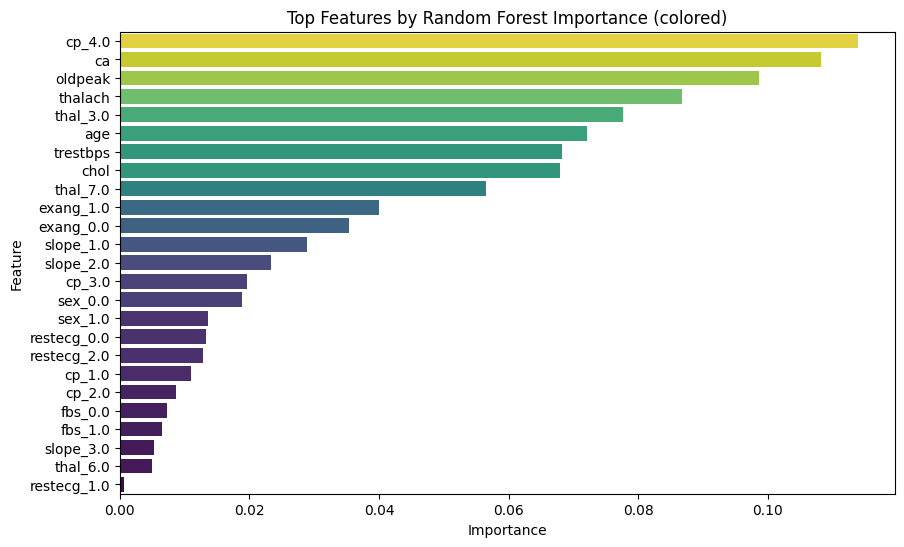

In [5]:
plt.figure(figsize=(10,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_imp,
    hue="Importance",
    dodge=False,
    legend=False,
    palette="viridis"
)
plt.title("Top Features by Random Forest Importance")
plt.show()

# RFE (Recursive Feature Elimination)

In [6]:
model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)

selected_features_rfe = X.columns[rfe.support_]
"Selected features by RFE:", selected_features_rfe.tolist()

('Selected features by RFE:',
 ['oldpeak',
  'ca',
  'sex_0.0',
  'cp_1.0',
  'cp_3.0',
  'cp_4.0',
  'exang_0.0',
  'slope_2.0',
  'thal_3.0',
  'thal_7.0'])

# Use Chi-Square Test

In [7]:
# Chi-square requires non-negative data → apply MinMax scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

chi_selector = SelectKBest(score_func=chi2, k=10)
chi_selector.fit(X_scaled, y)

chi_scores = pd.DataFrame({
    "Feature": X.columns,
    "Chi2 Score": chi_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

f"Top 10 features by Chi-Square:\n", chi_scores.head(10)

('Top 10 features by Chi-Square:\n',
       Feature  Chi2 Score
 24   thal_7.0   42.958360
 11     cp_4.0   42.410097
 18  exang_1.0   38.052613
 22   thal_3.0   36.592219
 5          ca   28.038394
 19  slope_1.0   24.086540
 10     cp_3.0   21.551109
 20  slope_2.0   20.624160
 17  exang_0.0   18.466709
 6     sex_0.0   15.785218)

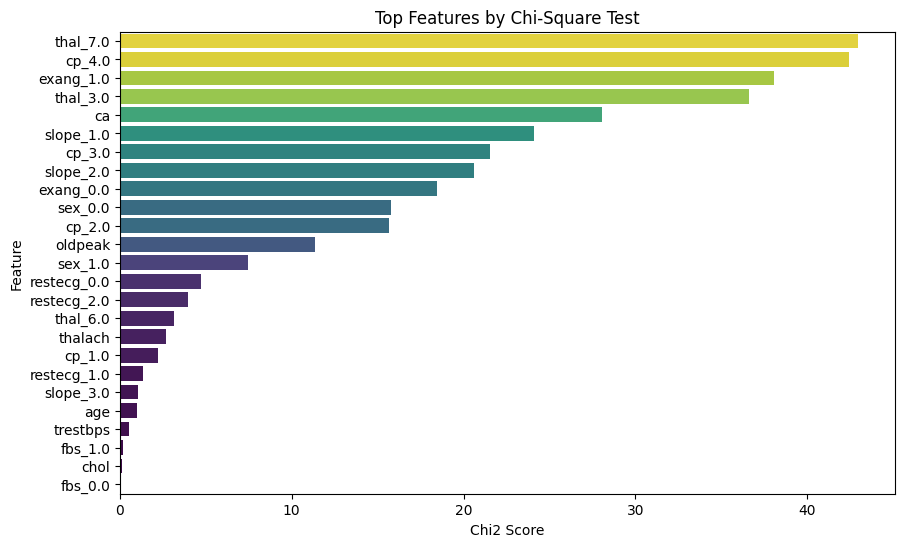

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x="Chi2 Score", y="Feature", data=chi_scores,
    hue="Chi2 Score",
    dodge=False,
    legend=False,
    palette="viridis")
plt.title("Top Features by Chi-Square Test")
plt.show()

# Compine the top features from all

In [9]:
# Take union of top features from all methods
top_rf = set(feat_imp.head(10)["Feature"])
top_rfe = set(selected_features_rfe)
top_chi = set(chi_scores.head(10)["Feature"])

final_features = list(top_rf | top_rfe | top_chi)
f"Final selected features:", final_features, ">>> Count:" ,len(final_features)

('Final selected features:',
 ['exang_0.0',
  'exang_1.0',
  'slope_2.0',
  'cp_4.0',
  'cp_1.0',
  'ca',
  'slope_1.0',
  'thal_3.0',
  'oldpeak',
  'age',
  'sex_0.0',
  'cp_3.0',
  'thalach',
  'trestbps',
  'chol',
  'thal_7.0'],
 '>>> Count:',
 16)

In [10]:
compare_df = pd.DataFrame(index=sorted(list(top_rf | top_chi | top_rfe)))
compare_df["RandomForest"] = compare_df.index.isin(top_rf)
compare_df["ChiSquare"] = compare_df.index.isin(top_chi)
compare_df["RFE"] = compare_df.index.isin(top_rfe)

print("Feature Selection Comparison Table")
compare_df

Feature Selection Comparison Table


,RandomForest,ChiSquare,RFE
age,True,False,False
ca,True,True,True
chol,True,False,False
cp_1.0,False,False,True
cp_3.0,False,True,True
cp_4.0,True,True,True
exang_0.0,False,True,True
exang_1.0,True,True,False
oldpeak,True,False,True
sex_0.0,False,True,True


In [11]:
# Show intersection (features selected by all methods)
common_features = top_rf & top_chi & top_rfe
print("Common selected features across all methods:", list(common_features))

Common selected features across all methods: ['cp_4.0', 'thal_3.0', 'thal_7.0', 'ca']


# Build & save reduced dataset

In [12]:
df_selected = df[final_features + [label_col]]
print("Reduced dataset shape:", df_selected.shape)

Reduced dataset shape: (303, 17)


In [13]:
df_selected.to_csv("data/heart_disease_selected.csv", index=False)
print("Feature-selected dataset saved at: data/heart_disease_selected.csv")

Feature-selected dataset saved at: data/heart_disease_selected.csv


# Thanks